# End-to-end Tutorial
In this tutorial, we will walk through a simple example of how to run our adaptive pilot sampling algorithm for multi-fidelity UQ pilot sampling.
This code requires [MXMCPy](https://github.com/nasa/MXMCPy) installed and should be run directly from the Tutorials folder.

## Imports
First, we will import the necessary packages. In particular, we assume that the user has specified their own <code> model_utils.py</code> file that specifies how to sample from the input distributions and run each model. For this demonstration, we use <code> model_utils_mono.py</code>, the monomial example from many multi-fidelity UQ benchmark problems.

In [6]:
import os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm, invwishart
module_directory = os.path.abspath('../src/') 
sys.path.insert(0, module_directory) 
from PilotStudy import PilotStudy
import model_utils_mono
import corr_utils

## Define MFUQ Problem
Next, we define all the necessary parameters (total budget, model costs vector) and initialize an instance of the <code> PilotStudy</code> object. This object handles all of the pilot sampling termination algorithm steps, including inference and projected posteriors.

In [4]:
n_models = 4           # Number of models
w = torch.tensor([[1.],[0.1],[0.01],[0.001]]) # model costs
pilot_cost = w.sum().item()
total_budget = 200*pilot_cost
seed = 42
x = 0. # this is meaningless for mono study
pilot_study = PilotStudy(model_utils=model_utils_mono, 
                         x=x, 
                         total_budget=total_budget,  
                         n_models=n_models, 
                         w=w,
                         seed=seed)


# Define Covariance Prior
We now define our prior on the covariance matrix. We will use a weakly informative $\gamma$-Gaussian (multivariate) prior on the correlation matrix parameters, and independent Gaussian priors on each $\log(\sigma)$ standard deviation parameters for this demonstration. We utilize the Inverse Wishart prior to set the prior $\gamma$-Gaussian means and standard deviations, as described in the paper.

The <code> PilotStudy.initialize_gamma_mvn_prior</code> and <code> PilotStudy.initialize_log_sigma_prior</code> functions are used to initialize our priors.

In [7]:
mean_corr_prior = np.array([[1    , 0.975, 0.95, 0.925],
                            [0.975, 1   ,  0.95, 0.95],
                            [0.95 , 0.95 , 1   , 0.95],
                            [0.925, 0.95 , 0.95, 1  ]])
mean_sds_prior = np.array([.1, .1, .1, .1])
mean_cov_prior = np.diag(mean_sds_prior) @ mean_corr_prior @ np.diag(mean_sds_prior)
nu_prior = n_models + 2
S_prior = mean_cov_prior*(nu_prior-n_models-1)
cov_prior_samps_iw = invwishart.rvs(df=nu_prior, scale=S_prior, size=400, random_state=seed).T
corr_prior_samps_iw = corr_utils.covs2corrs(cov_prior_samps_iw)

# moment matching for equivalent GG covariance or variance
gamma_samps_init = corr_utils.corrs_to_gammas_1d(corr_prior_samps_iw)
gam_cov_equiv = np.cov(gamma_samps_init)
gamma_means = corr_utils.GFT_forward_mapping(mean_corr_prior)
pilot_study.initialize_gamma_mvn_prior(gamma_means, gam_cov_equiv)

# also need to define log-normal stdev prior for full covariance info
log_sigma_means = np.log(np.array([.1, .1, .1, .1]))
log_sigma_sigs = np.ones((n_models,))
pilot_study.initialize_log_sigma_prior(log_sigma_means, log_sigma_sigs)

# Run adaptive pilot sampling algorithm
Finally, it is time to perform pilot sampling. The <code> PilotStudy.find_n_star_gg_mvn</code> function performs the adaptive pilot sampling loop. Here we set the algorithm hyperparameters as follows: step size $k=2$, number of MC samples to evaluate each expected loss $N_{MC}=50$, and we select $\Sigma'$ by using the posterior mean. We use a low $N_{MC}=50$ to keep this tutorial fast, but in real applications this value may need to be larger to get the MC error low for each expected loss evaluation.

With <code> estimate</code> set to <code> True</code>, the final ACV estimator is also run with the remaining budget.

The two columns of printed output correspond to the current and next-step (projected) expected losses. When the next-step expected loss exceeds the current expected loss, the algorithm terminates.

In [9]:
n_mc = 50
outs_list_500_gg_mvn = []
oracle_evals_list_500_gg_mvn = []
oracle_lim_budg_list_500_gg_mvn = []
c_hat_full_budg_list_500_gg_mvn = []

results = pilot_study.find_n_star_gg_mvn(x, 
                                        batch_size=2, 
                                        start=6, 
                                        stop=100, 
                                        n_mc=n_mc, 
                                        seed=seed, 
                                        sigma_prime='mean', 
                                        estimate=True)

(current_expected_losses,
 current_losses, 
 next_expected_losses, 
 next_losses, 
 budgets_used, 
 sigma_prime, 
 budget_remaining, 
 pilot_evals, 
 var_estimates, 
 acv_eval) = results

Running projected loss loop for batch size 6 and ACV budget 215.5
2.0275435189669695 1.9416361990207553
Running projected loss loop for batch size 8 and ACV budget 213.3
1.895116804075196 1.670501396052221
Running projected loss loop for batch size 10 and ACV budget 211.0
1.540952055216818 1.427913070649408
Running projected loss loop for batch size 12 and ACV budget 208.8
1.5340315872885482 1.4614132781460134
Running projected loss loop for batch size 14 and ACV budget 206.6
1.4309470151991905 1.4188457149006002
Running projected loss loop for batch size 16 and ACV budget 204.4
1.4320187544319065 1.2960586438090251
Running projected loss loop for batch size 18 and ACV budget 202.2
1.2902597251332577 1.2421775236305945
Running projected loss loop for batch size 20 and ACV budget 199.9
1.2491497325477703 1.26669249703817
Termination met at iteration 20


# Analyze Results

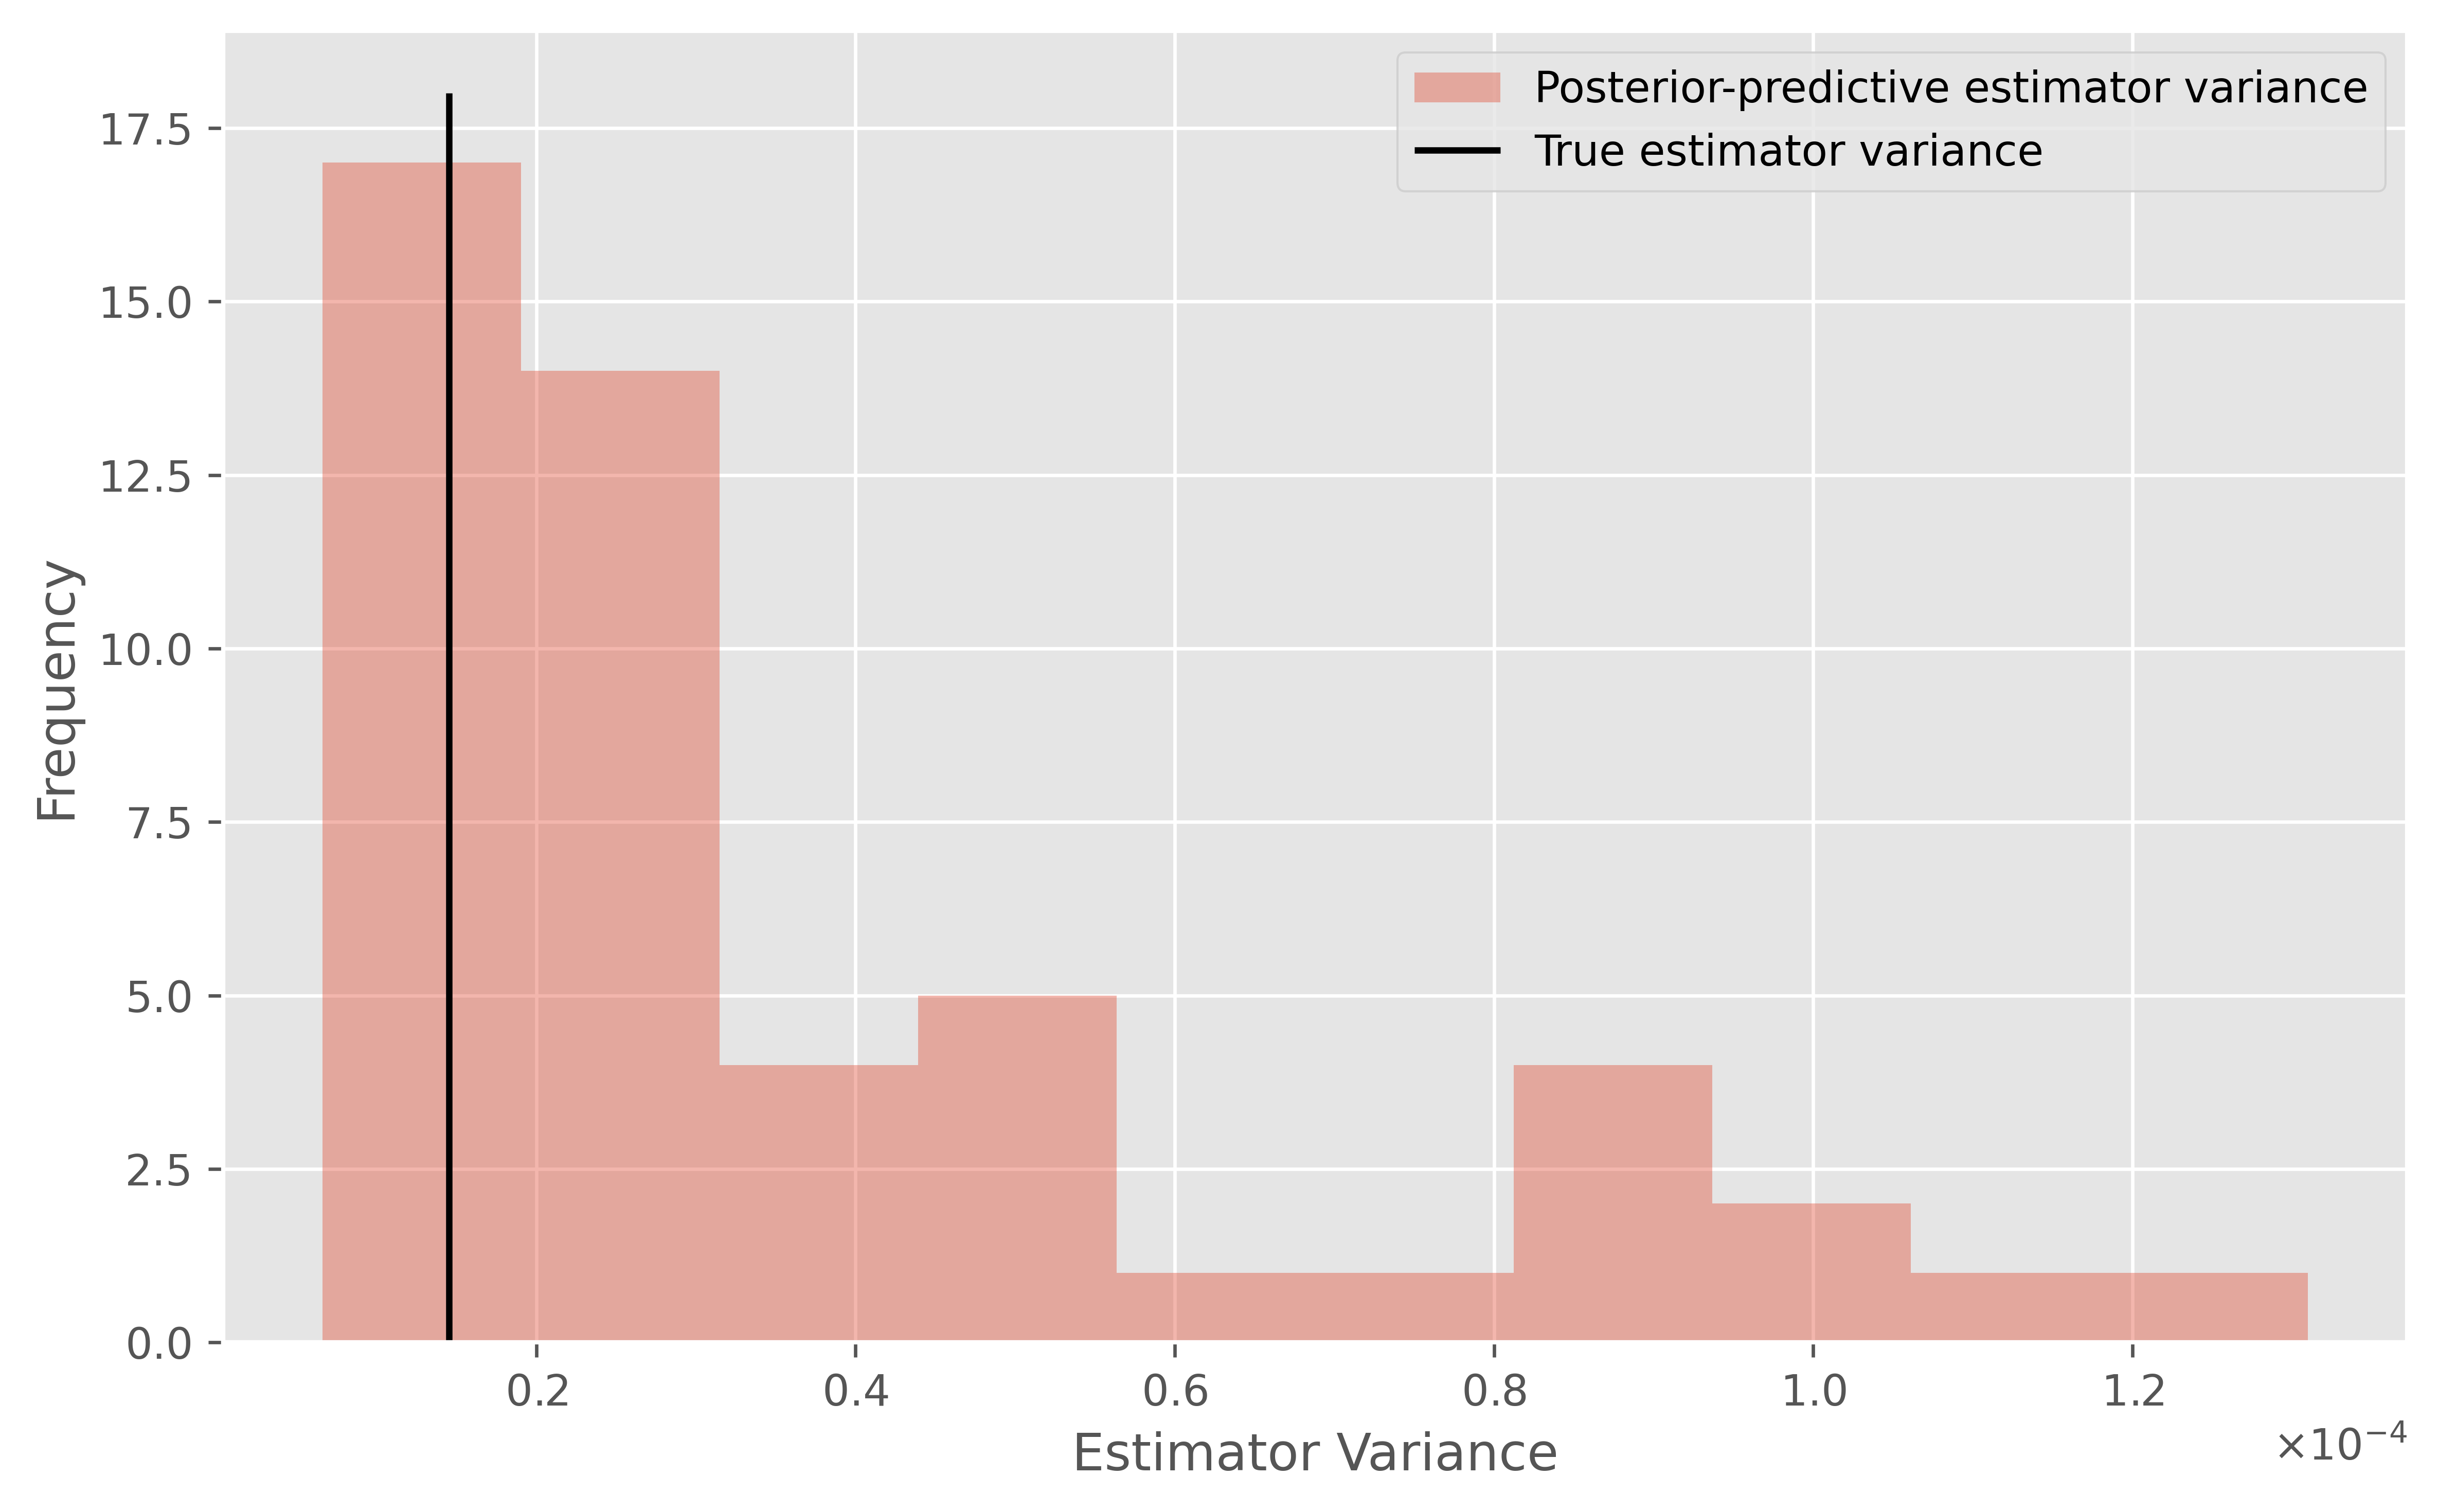

ACV estimate of HF mean:
0.16606813482525343
Posterior-predictive 80/20 credible interval of predicted estimator variance:
1.3825979078222438e-05
5.5266601423495e-05
True estimator variance (oracle)
1.4520526307845684e-05


In [17]:
oracle_cov = model_utils_mono.sig_func().detach().numpy()
oracle_var = np.diag(oracle_cov)
oracle_corr = corr_utils.cov2corr(oracle_cov.copy())
true_var = pilot_study.compute_oracle_acv_variance(sigma_prime, budget_remaining, oracle_cov, w, estimator='wrdiff')

from matplotlib.ticker import ScalarFormatter

plt.figure(figsize=(8, 5))
plt.hist(var_estimates, alpha=0.4, label='Posterior-predictive estimator variance')
plt.vlines(true_var, 0, 18, colors='black', label='True estimator variance')
plt.xlabel('Estimator Variance')
plt.ylabel('Frequency')
plt.legend()

# Set x-ticks to scientific notation
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.tight_layout()
plt.show()

print("ACV estimate of HF mean:")
print(acv_eval)
print("Posterior-predictive 80/20 credible interval of predicted estimator variance:")
print(np.quantile(var_estimates,0.2))
print(np.quantile(var_estimates,0.8))
print("True estimator variance (oracle)")
print(true_var)